In [43]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(transform_output="pandas")
from preprocessing_93 import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter('ignore')
RSEED = 5


df = pd.read_csv("data/AQUASTAT_complete.csv")


pre_split_processor = get_pre_split_processor_93()
df_pre = pre_split_processor.fit_transform(df)


df_pre = df_pre.query("year > 2010")

full_preprocessor = get_full_preprocessor_93(df_pre.columns.to_list(), hot=False)

df_pro = full_preprocessor.fit_transform(df_pre)



In [44]:
df_pro.head()



,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,groundwater_accounted_inflow,...,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable,country,year,gdp_per_capita,water_stress,total_population_with_access_to_safe_drinking_water
47,0.431064,-0.126409,1.024654,0.922577,1.31297,1.462224,0.714718,0.186834,0.084165,-0.087237,...,-0.372913,0.907728,0.723942,0.092313,-0.202583,Afghanistan,2011,576.101770,54.757019,49.8
48,0.431064,-0.126409,1.024654,0.922577,1.31297,1.402036,0.714718,0.183160,0.084165,-0.087237,...,-0.391123,0.907728,0.684609,0.117968,-0.202583,Afghanistan,2012,614.109574,54.757019,51.6
49,0.431064,-0.126409,1.024654,0.922577,1.31297,1.369254,0.714718,0.179392,0.084165,-0.087237,...,-0.409797,0.907728,0.644734,0.143855,-0.202583,Afghanistan,2013,608.058642,54.757019,53.4
50,0.431064,-0.126409,1.024654,0.922577,1.31297,1.349713,0.714718,0.175775,0.084165,-0.087237,...,-0.427728,0.907728,0.606879,0.168919,-0.202583,Afghanistan,2014,585.862673,54.757019,55.2
51,0.431064,-0.126409,1.024654,0.922577,1.31297,1.251554,0.714718,0.172457,0.084165,-0.087237,...,-0.444171,0.907728,0.572536,0.192486,-0.202583,Afghanistan,2015,543.768940,54.757019,55.3


In [45]:
label_encoder = LabelEncoder()
df_pro['country'] = label_encoder.fit_transform(df_pro['country'])

In [46]:
from tsfresh import extract_features

# Extract columns
value_columns = df_pro.drop(columns=['country', 'year']).columns

# Initialize lists to store data for long format dataframe
ids = []
times = []
values = []
names = []

# Loop through each value column and append data to lists
for col in value_columns:
    ids.extend(df_pro['country'].values)
    times.extend(df_pro['year'].values)
    values.extend(df_pro[col].values)
    names.extend([col] * len(df_pro))

# Create long format dataframe
long_data = pd.DataFrame({
    'id': ids,
    'time': times,
    'value': values,
    'variable': names
})

long_data.tail()


,id,time,value,variable
59565,160,2016,76.9,total_population_with_access_to_safe_drinking_...
59566,160,2017,76.9,total_population_with_access_to_safe_drinking_...
59567,160,2018,76.9,total_population_with_access_to_safe_drinking_...
59568,160,2019,76.9,total_population_with_access_to_safe_drinking_...
59569,160,2020,76.9,total_population_with_access_to_safe_drinking_...


In [47]:
long_data = long_data[pd.to_numeric(long_data['value'], errors='coerce').notnull()]

In [48]:
print(long_data['value'].apply(type).unique())

[<class 'float'>]


In [49]:
# Extract features
custom_fc_parameters = {
    "mean": None,
    "mean_change": None,
    
    # Add more features as needed
}




features = extract_features(long_data, default_fc_parameters=custom_fc_parameters, column_id='id', column_sort='time', column_value='value')
print(features.columns)
print(features.head())


Feature Extraction:  50%|█████     | 5/10 [00:00<00:00, 48.20it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 46.11it/s]

Index(['value__mean', 'value__mean_change'], dtype='object')
   value__mean  value__mean_change
0    17.856274            0.148696
1   126.864642            0.256555
2   129.565239            0.225390
3   109.827327            0.140662
4   347.041223            0.267395


In [50]:
from sklearn.preprocessing import StandardScaler

# Replace NaN values with 0 or use imputation techniques
features.fillna(0, inplace=True)

# Scale the imputed features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [51]:
print(features.head())


   value__mean  value__mean_change
0    17.856274            0.148696
1   126.864642            0.256555
2   129.565239            0.225390
3   109.827327            0.140662
4   347.041223            0.267395


In [52]:
# from sklearn.decomposition import PCA


# # Apply PCA to reduce dimensionality
# pca = PCA(n_components=0.95)  # Retain 95% of the variance
# reduced_features = pca.fit_transform(features)
# num_pcs = pca.n_components_
# print(f"Number of principal components: {num_pcs}")
# print(pca.explained_variance_ratio_)

In [53]:
# pca_2d = PCA(n_components=2)
# reduced_2d = pca_2d.fit_transform(scaled_features)

In [62]:
import hdbscan
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Initialize HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=5, gen_min_span_tree=True)

# Fit the model
#clusters_hdbscan = clusterer.fit_predict(reduced_features)
clusters_hdbscan = clusterer.fit_predict(features)

print(np.unique(clusters_hdbscan))





[-1  0  1  2  3  4  5  6  7  8  9 10]


In [68]:
# Minimum Cluster Size

min_cluster_size = 5
clusterer = hdbscan.HDBSCAN(min_samples=5, gen_min_span_tree=True, min_cluster_size=min_cluster_size)
clusters_hdbscan = clusterer.fit_predict(features)
print("Clusters with minimum cluster size:", np.unique(clusters_hdbscan))



Clusters with minimum cluster size: [-1  0  1  2  3  4  5  6  7  8  9 10]


In [66]:
# Silhouette Score
best_score = -1
best_clusterer = None
for min_cluster_size in range(5, 20):  # Adjust the range as needed
    clusterer = hdbscan.HDBSCAN(min_samples=5, gen_min_span_tree=True, min_cluster_size=min_cluster_size)
    clusters = clusterer.fit_predict(features)
    silhouette_avg = silhouette_score(features, clusters)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_clusterer = clusterer
    print("min_cluster_size: ",min_cluster_size , silhouette_avg)
print("Best silhouette score:", best_score)
print("Clusters with best silhouette score:", np.unique(best_clusterer.labels_))



min_cluster_size:  5 0.2988976048402064
min_cluster_size:  6 0.29364470853574365
min_cluster_size:  7 0.19855651515088263
min_cluster_size:  8 0.19855651515088263
min_cluster_size:  9 0.19855651515088263


min_cluster_size:  10 0.2059453367079711
min_cluster_size:  11 0.16176773722007431
min_cluster_size:  12 0.7398512707473366
min_cluster_size:  13 0.7398512707473366
min_cluster_size:  14 0.7398512707473366
min_cluster_size:  15 0.7398512707473366
min_cluster_size:  16 0.7398512707473366
min_cluster_size:  17 0.30595902125047725
min_cluster_size:  18 0.16349519648255598
min_cluster_size:  19 0.16349519648255598
Best silhouette score: 0.7398512707473366
Clusters with best silhouette score: [-1  0  1]


In [70]:
# Calinski-Harabasz Index
best_score = -1
best_clusterer = None
for min_cluster_size in range(5, 20):  # Adjust the range as needed
    clusterer = hdbscan.HDBSCAN(min_samples=5, gen_min_span_tree=True, min_cluster_size=min_cluster_size)
    clusters = clusterer.fit_predict(features)
    ch_score = calinski_harabasz_score(features, clusters)
    if ch_score > best_score:
        best_score = ch_score
        best_clusterer = clusterer
    print("min_cluster_size: ",min_cluster_size , ch_score)
print("Best Calinski-Harabasz score:", best_score)
print("Clusters with best Calinski-Harabasz score:", np.unique(best_clusterer.labels_))

min_cluster_size:  5 14.513625113627214
min_cluster_size:  6 18.793655354141897
min_cluster_size:  7 20.350452926198177
min_cluster_size:  8 20.350452926198177
min_cluster_size:  9 20.350452926198177
min_cluster_size:  10 24.304499526460933
min_cluster_size:  11 28.165479552740265
min_cluster_size:  12 374.35813301461974
min_cluster_size:  13 374.35813301461974
min_cluster_size:  14 374.35813301461974
min_cluster_size:  15 374.35813301461974
min_cluster_size:  16 374.35813301461974
min_cluster_size:  17 48.576606145737756
min_cluster_size:  18 36.08178586144096
min_cluster_size:  19 36.08178586144096
Best Calinski-Harabasz score: 374.35813301461974
Clusters with best Calinski-Harabasz score: [-1  0  1]


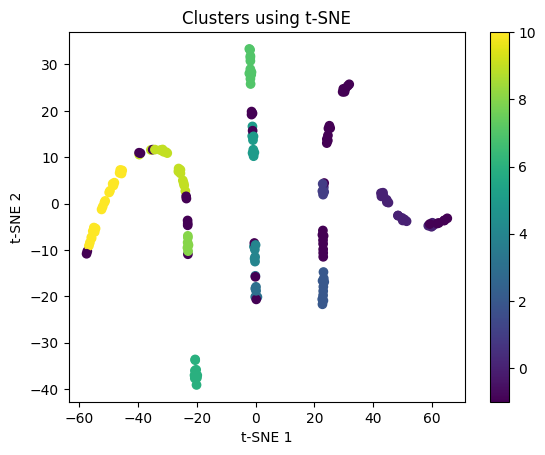

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE and reduce to 2 dimensions
tsne_vis = TSNE(n_components=2, random_state=5, perplexity=5, learning_rate=20)  # setting random_state for reproducibility
reduced_vis_tsne = tsne_vis.fit_transform(features)

# Plot
plt.scatter(reduced_vis_tsne[:, 0], reduced_vis_tsne[:, 1], c=clusters_hdbscan, cmap='viridis')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters using t-SNE')
plt.colorbar()
plt.show()






In [71]:
# add the cluster labels from HDBSCAN
cluster_df = pd.DataFrame({
    'country': features.index,  # Assuming that the index of 'features' is the country ID.
    'cluster': clusters_hdbscan
})

df_pro = pd.merge(df_pro, cluster_df, on='country', how='left')

df_pro['country'] = label_encoder.inverse_transform(df_pro['country'])

# filter by cluster
for cluster_label in np.unique(clusters_hdbscan):
    print(f"Cluster {cluster_label}:")
    countries_in_cluster = df_pro[df_pro['cluster'] == cluster_label]['country'].unique()
    print(countries_in_cluster)
    print("\n")

for cluster_label in np.unique(clusters_hdbscan):
    print(f"Summary for Cluster {cluster_label}:")
    print(df_pro[df_pro['cluster'] == cluster_label].describe())
    print("\n")

for cluster_label in np.unique(clusters_hdbscan):
    print(f"Summary for Cluster {cluster_label}:")
    print(df_pro[df_pro['cluster'] == cluster_label].describe())
    print("\n")

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [58]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model
#clusters_dbscan = dbscan.fit_predict(reduced_features)
clusters_dbscan = dbscan.fit_predict(features)

print(np.unique(clusters_dbscan))



[-1]


In [59]:
# Plot using DBSCAN clusters
plt.scatter(reduced_vis.iloc[:, 0], reduced_vis.iloc[:, 1], c=clusters_dbscan, cmap='viridis')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clusters using PCA')
plt.colorbar()
plt.show()

NameError: name 'reduced_vis' is not defined

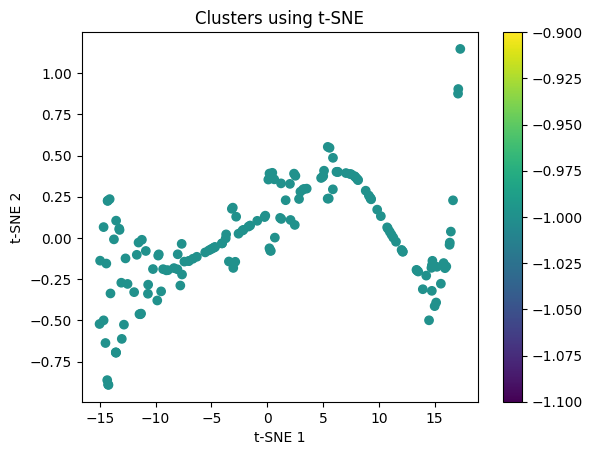

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE and reduce to 2 dimensions
tsne_vis = TSNE(n_components=2, random_state=5, perplexity=30, learning_rate=20)  # setting random_state for reproducibility
reduced_vis_tsne = tsne_vis.fit_transform(features)

# Plot
plt.scatter(reduced_vis_tsne[:, 0], reduced_vis_tsne[:, 1], c=clusters_dbscan, cmap='viridis')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Clusters using t-SNE')
plt.colorbar()
plt.show()